In [76]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

In [4]:
__file__ = 'C:/Users/antie/Documents/Pole_recherche/Tsunami'

In [5]:
__file__ = 'C:/Users/Gilles/CS/cours/PoleProjet/FormationRecherche/Tsunami/TP/sceance4/Tsunami'

In [6]:
import os

print(os.getcwd())
os.chdir(__file__)
print(os.getcwd())

c:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami\differentiate
C:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami


In [7]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

## Create the model

In [118]:
# méthode API Sequential
multilayer_perceptron = keras.models.Sequential([
  keras.layers.Input(shape=(2)),
  #keras.layers.GaussianNoise(stddev=1e-3),
  keras.layers.Dense(20,activation='elu'),
  keras.layers.Dense(20,activation='elu'),
  keras.layers.Dense(20,activation='elu'),
  keras.layers.Dense(1, use_bias=False)
])

In [9]:
multilayer_perceptron.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 20        
                                                                 
Total params: 920
Trainable params: 920
Non-trainable params: 0
_________________________________________________________________


In [113]:
print(len(multilayer_perceptron.trainable_variables))

8


In [114]:
learning_rate = 0.01
training_steps = 1
batch_size = 2
display_step = 1

optimizer = tf.optimizers.Adam(lr=learning_rate)

C:\Users\Gilles\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
import Polynomials.polynome4students_v2 as Pstud

frontier_coords = Pstud._set_coords_rectangle(1,1,40)

F_xpy_real = Pstud._set_polynome_xpy_numpy_real(frontier_coords)
F_expxpy_real = Pstud._set_polynome_expxpy_numpy_real(frontier_coords)
F_sinxpy_real = Pstud._set_polynome_sinxpy_numpy_real(frontier_coords)

F_xpy_cmplx = Pstud._set_polynome_xpy_numpy_cmplx(frontier_coords)

In [115]:

# Universal Approximator
def g(x):
  # F_x = Pstud._eval_polynome_numpy(F_xpy_real,x[0,0],x[0,1])
  N_x = multilayer_perceptron(x)
  return N_x

# Given EDO
def f(X):
  return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])

def residual(du_dxx,du_dyy,f_ind):
  return du_dxx+du_dyy+f_ind


def differentiate(model,x):
  with tf.GradientTape(persistent=True) as tape:
    x1, x2 = x[:,0:1], x[:,1:2]
    tape.watch(x1)
    tape.watch(x2)
    u = model(tf.stack([x1[:,0], x2[:,0]], axis=1))
    du_dx = tape.gradient(u,x1)
    du_dy = tape.gradient(u,x2)
  du_dxx = tape.gradient(du_dx,x1) 
  du_dyy = tape.gradient(du_dy,x2)
  return du_dxx,du_dyy




X = np.linspace(0,1,100)
Y = np.linspace(0,1,100)
coords = [tf.constant([x,y],dtype=DTYPE) for x in X for y in Y]

# Custom loss function to approximate the derivatives
def custom_loss():
  indices = np.random.randint(len(coords),size=batch_size)
  sample_coords = [coords[i] for i in indices]

  tf_sample_coords = tf.convert_to_tensor(sample_coords)

  dg_dxx,dg_dyy = differentiate(g,tf_sample_coords)
  # print(dg_dxx,dg_dyy)
  f_r = tf.reshape(f(tf_sample_coords),[batch_size,1])
  # print(tf.concat([dg_dxx+dg_dyy,f_r],axis=1))
  print('dg_dxx\n', dg_dxx)
  print('f_r \n',f_r)
  res = residual(dg_dxx,dg_dyy,f_r)
  # choose an L2 norm ? Could we find other losses ?
  print('concat;\n', tf.concat([dg_dxx+dg_dyy,-f_r],axis=1))
  loss = tf.reduce_mean(tf.square(res))
  print('loss :', loss)
  return loss

In [116]:
indices = np.random.randint(len(coords),size=batch_size)
sample_coords = [coords[i] for i in indices]

tf_sample_coords = tf.convert_to_tensor(sample_coords)
print(tf_sample_coords)

tf.Tensor(
[[0.969697   0.42424244]
 [0.8080808  0.959596  ]], shape=(2, 2), dtype=float32)


## Train the model

epoch: 0
dg_dxx
 tf.Tensor(
[[-0.0686704 ]
 [-0.17708547]], shape=(2, 1), dtype=float32)
f_r 
 tf.Tensor(
[[0.03179343]
 [0.50503844]], shape=(2, 1), dtype=float32)
concat;
 tf.Tensor(
[[-0.33172005 -0.03179343]
 [-0.54677314 -0.50503844]], shape=(2, 2), dtype=float32)
loss : tf.Tensor(0.045848876, shape=(), dtype=float32)
dg_dxx
 tf.Tensor(
[[0.03790201]
 [0.02751628]], shape=(2, 1), dtype=float32)
f_r 
 tf.Tensor(
[[0.6734966]
 [0.4671732]], shape=(2, 1), dtype=float32)
concat;
 tf.Tensor(
[[-0.08907005 -0.6734966 ]
 [-0.12633745 -0.4671732 ]], shape=(2, 2), dtype=float32)
loss : tf.Tensor(0.22886169, shape=(), dtype=float32)
loss: 0.228862 


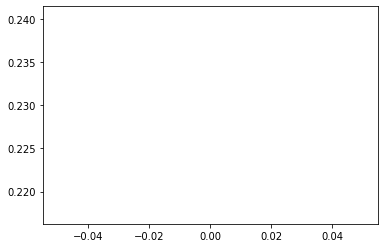

In [117]:
def train_step():
  with tf.GradientTape() as tape:
      loss = custom_loss()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))


# Training the Model:

all_losses = []
for i in range(training_steps):
  print ('epoch:',i)
  train_step()
  loss = custom_loss()
  if i % display_step == 0:
    print("loss: %f " % (loss))
  all_losses.append(loss)

plt.plot(np.arange(0,training_steps),all_losses)
plt.show()

## Compare to the true solution

In [22]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [67]:
def true_function(X):
    return -tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])/(np.pi**2)

def false_appro_function(X):
    return -tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])/(np.pi**2)+1

In [110]:
tf_coords = tf.convert_to_tensor(coords)
# print(tf.reshape(tf_coords,[100,100,2]))
# print(tf.reshape(tf_coords,[100,100,2])[-1])

true_values = tf.reshape(true_function(tf_coords),[100,100]).numpy()
appro_values = tf.reshape(g(tf_coords),[100,100]).numpy()
error = np.abs(true_values-appro_values)

print(error.shape)

(100, 100)


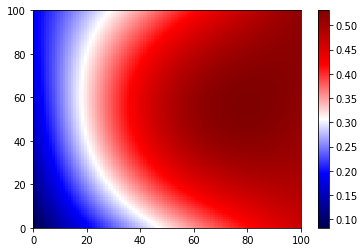

In [111]:
new_inferno = cm.get_cmap('seismic', 1024)
# visualize with the new_inferno colormaps
plt.pcolormesh(error, cmap = new_inferno)
plt.colorbar()

## Save the model

In [21]:
multilayer_perceptron.save('differentiate/model_EDP_2D.h5')

## Load the model

In [18]:
multilayer_perceptron = keras.models.load_model('differentiate/model_EDP_2D.h5')

# Questions 

Quelle architecture ? 

Comment éviter l'overfitting ?

Comment exploiter les avantages de l'IA ?

Choix de l'optimizer + regularizer ? + Implémentation ?

Implémentation de système d'EDP à plusieurs inconnues (étant des fonctions bien sûr) ?

Plus rapide ? Comment enlever les boucles `for` ? => batch_gradient_descent ?

Besoin de batch_normalization ? + autres hyperparamètres ?

# Idées

Ajout de bruit en entrée contre l'overfitting 

Une sortie par inconnue